<a href="https://colab.research.google.com/github/afifaniks/triagerX/blob/main/notebook/Fine_Tune_Llama_2_with_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 16 14:56:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  NVIDIA A100 80G...  On   | 00000000:17:00.0 Off |                    0 |
| N/A   31C    P0    51W / 300W |      0MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


In [2]:
!pip install accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 transformers==4.31.0 trl==0.4.7 torch scipy pandas matplotlib

In [1]:
import os
import re
import torch
from datasets import load_dataset
import pandas as pd
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    StoppingCriteria, 
    StoppingCriteriaList
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

## Data Exploration

In [2]:
data_path = "data/openj9/openj9_issues.csv"
df = pd.read_csv(data_path)
df = df.drop("Unnamed: 0", axis=1)

df.head()

,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees
0,10,https://github.com/eclipse-openj9/openj9/pull/10,Update README.md with proper AdoptOpenJDK link,"Also remove the the coming soon reference, sin...",closed,pshipton,NaN,charliegracie
1,15,https://github.com/eclipse-openj9/openj9/pull/15,Refactor and clean up CodeCacheManager,- Change invocation parameters of superclass c...,closed,lmaisons,<comment><user>lmaisons</user><body>This has a...,0xdaryl
2,17,https://github.com/eclipse-openj9/openj9/pull/17,WIP Add support for function pointers in Panama,When invoking a native function (with Panama) ...,closed,tajila,<comment><user>tajila</user><body>Thanks for t...,DanHeidinga
3,22,https://github.com/eclipse-openj9/openj9/pull/22,fix illegal-access behaviour,fix illegal-access behaviour\r\n\r\nThis is th...,closed,tajila,<comment><user>DanHeidinga</user><body>@tajila...,DanHeidinga
4,24,https://github.com/eclipse-openj9/openj9/issue...,Enable a travis.ci-based PR build for linux x8...,Build a basic PR build based off the linux_x86...,closed,DanHeidinga,<comment><user>mgaudet</user><body>This has be...,DanHeidinga


In [3]:
df[5000:5005]

,issue_number,issue_url,issue_title,issue_body,issue_state,creator,comments,assignees
5000,16649,https://github.com/eclipse-openj9/openj9/issue...,Scripts not permitted to use staticMethod org....,https://openj9-jenkins.osuosl.org/job/Test_ope...,closed,pshipton,<comment><user>llxia</user><body>`makeTap13Yam...,AdamBrousseau
5001,16650,https://github.com/eclipse-openj9/openj9/pull/...,Implement JITServer AOT cache thunk handling,These commits add J2I thunk handling to the JI...,closed,cjjdespres,<comment><user>cjjdespres</user><body>Attn @mp...,mpirvu
5002,16652,https://github.com/eclipse-openj9/openj9/issue...,Skynet failures on larger machines,The Skynet test fails readily (maybe 1 in 5 ru...,closed,0xdaryl,<comment><user>0xdaryl</user><body>FYI @fengxu...,LinHu2016
5003,16655,https://github.com/eclipse-openj9/openj9/issue...,jdk20 OpenJDK java/lang/Class/getEnumConstants...,https://openj9-jenkins.osuosl.org/job/Test_ope...,closed,pshipton,NaN,pshipton
5004,16656,https://github.com/eclipse-openj9/openj9/issue...,jdk20 OpenjDK java/lang/Thread/jni/AttachCurre...,https://openj9-jenkins.osuosl.org/job/Test_ope...,closed,pshipton,<comment><user>pshipton</user><body>@tajila fy...,babsingh


In [4]:
total_contributors = len(df["assignees"].unique())
print(f"Total contributors: {total_contributors}")

Total contributors: 127


In [5]:
minimum_contribution = 30

developers = df["assignees"].value_counts()

In [6]:
filtered_developers = developers.index[developers >= minimum_contribution]

In [7]:
filtered_df = df[df["assignees"].isin(filtered_developers)]

<Axes: xlabel='assignees'>

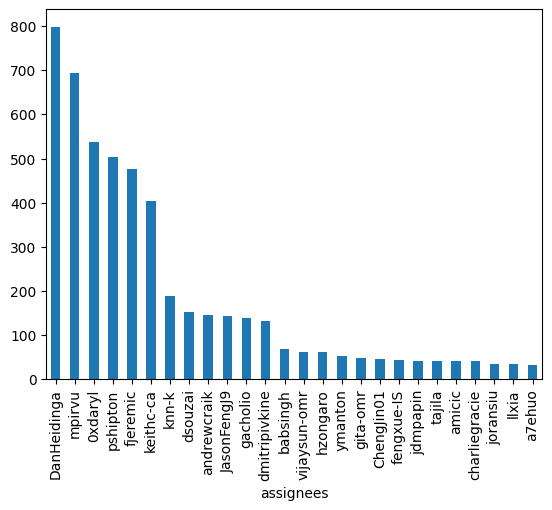

In [8]:
filtered_df["assignees"].value_counts().plot(kind="bar")

In [9]:
filtered_df.to_csv("data/openj9/openj9_issues_cleaned.csv")

## Model Configuration

In [10]:
model_name = "NousResearch/Llama-2-13b-chat-hf"
data_path = "data/openj9/openj9_issues_cleaned.csv"
new_model = "llama-2-13b-openj9"

# Set QLoRA configuration
lora_r = 64 # Attention dimension/rank
lora_alpha = 16
lora_dropout = 0.05

# Set bitsandbytes configuration
use_4bit = True #For  4-bit precision base model loading
bnb_4bit_compute_dtype = "float16" # Compute dtype for 4-bit base models
bnb_4bit_quant_type = "nf4" # Quantization type (fp4 or nf4)
use_nested_quant = False # Activate nested quantization for 4-bit base models (double quantization)


# Set training params
output_dir = "./results"
num_train_epochs = 1
fp16 = False
bf16 = False
per_device_train_batch_size = 8
per_device_eval_batch_size = 8
gradient_accumulation_steps = 1
gradient_checkpointing = True
max_grad_norm = 0.3
learning_rate = 2e-4
weight_decay = 0.001
optim = "paged_adamw_32bit"
lr_scheduler_type = "cosine"
max_steps = 300
warmup_ratio = 0.03
group_by_length = True # Group sequences into batches with same length saves memory and speeds up training considerably
save_steps = 0
logging_steps = 5

# Set SFT parameters
max_seq_length = None
packing = False # Pack multiple short examples in the same input sequence to increase efficiency
device_map = {"": 0} # Load the entire model on the GPU 0

In [11]:
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

## Load Base Model

In [12]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Using it for optimized model loading
    device_map=device_map
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [13]:
!pip install --no-cache-dir transformers sentencepiece

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix overflow issue with fp16 training

## Prompt Template Generation

In [15]:
# formatted_text = f"<s><INST>Issue Title:\n{data['issue_title'][i]}" \
#     + f"\nIssue Description:\n{data['description'][i]}\nWho can fix this issue?\n</INST>The issue can be fixed by: {data['owner'][i]}</s>"

import xml.etree.ElementTree as ET

def parse_comments(comments: str):
    xml_like =  ET.ElementTree(ET.fromstring(comments))

def generate_prompt_with_answer(entry, i):
    # comments = entry["comments"] # TBD

    issue_title = entry["issue_title"][i]
    issue_description = entry["issue_body"][i]
    assignees = entry["assignees"][i]
    
    prompt = f"""<s><INST>Suggest a developer from the given developer list based on the issue title and description given below. The name of developers are separated by comma. You have to choose only one based on previous knowledge. If the question cannot be answered using the information provided answer with "I don't know".
Developer List: {", ".join(filtered_developers.values)}

Issue Title: {issue_title}

Issue Description: {issue_description}
=====
Question: Which developer from the given Developer List can fix this issue?</INST>

Answer: {assignees}</s>
"""

    return prompt

def generate_prompt_without_answer(entry):
    issue_title = entry["issue_title"]
    issue_description = entry["issue_body"]

    prompt = f"""<s><INST>Suggest a developer from the given developer list based on the issue title and description given below. The name of developers are separated by comma. You have to choose only one based on previous knowledge. If the question cannot be answered using the information provided answer with "I don't know".
Developer List: {", ".join(filtered_developers.values)}

Issue Title: {issue_title}

Issue Description: {issue_description}
=====
Question: Which developer from the given Developer List can fix this issue?</INST>

Answer: </s>
"""

    return prompt



In [16]:
print(generate_prompt_with_answer(filtered_df, 477))

<s><INST>Suggest a developer from the given developer list based on the issue title and description given below. The name of developers are separated by comma. You have to choose only one based on previous knowledge. If the question cannot be answered using the information provided answer with "I don't know".
Developer List: DanHeidinga, mpirvu, 0xdaryl, pshipton, fjeremic, keithc-ca, knn-k, dsouzai, andrewcraik, JasonFengJ9, gacholio, dmitripivkine, babsingh, vijaysun-omr, hzongaro, ymanton, gita-omr, ChengJin01, fengxue-IS, jdmpapin, tajila, amicic, charliegracie, llxia, joransiu, a7ehuo

Issue Title: zLinux compilation failing

Issue Description: https://ci.eclipse.org/openj9/job/Build-JDK8-linux_390-64_cmprssptrs/318/
https://ci.eclipse.org/openj9/job/Build-JDK9-linux_390-64_cmprssptrs/257/
https://ci.eclipse.org/openj9/job/Build-JDK10-linux_390-64_cmprssptrs/156/
```
00:40:14 /home/jenkins/jenkins-agent/workspace/Build-JDK8-linux_390-64_cmprssptrs/build/linux-s390x-normal-server-r

## Test Base Model

In [17]:
device = f'cuda:{torch.cuda.current_device()}' if torch.cuda.is_available() else 'cpu'
stop_list = ['\nHuman:', '\n```\n']

stop_token_ids = [tokenizer(x)['input_ids'] for x in stop_list]
stop_token_ids = [torch.LongTensor(x).to(device) for x in stop_token_ids]

class StopOnTokens(StoppingCriteria):
    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        for stop_ids in stop_token_ids:
            if torch.eq(input_ids[0][-len(stop_ids):], stop_ids).all():
                return True
        return False

stopping_criteria = StoppingCriteriaList([StopOnTokens()])

In [18]:
def inference(model, tokenizer, prompt, max_length=20):
  total_response_length = len(tokenizer.tokenize(prompt)) + 8 + max_length
  pipe = pipeline(task="text-generation", model=model, max_length=total_response_length, tokenizer=tokenizer, stopping_criteria=stopping_criteria)
  result = pipe(prompt)

  return result[0]["generated_text"]

In [19]:
print(inference(model, tokenizer, generate_prompt_without_answer(filtered_df.iloc[300])))

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s><INST>Suggest a developer from the given developer list based on the issue title and description given below. The name of developers are separated by comma. You have to choose only one based on previous knowledge. If the question cannot be answered using the information provided answer with "I don't know".
Developer List: DanHeidinga, mpirvu, 0xdaryl, pshipton, fjeremic, keithc-ca, knn-k, dsouzai, andrewcraik, JasonFengJ9, gacholio, dmitripivkine, babsingh, vijaysun-omr, hzongaro, ymanton, gita-omr, ChengJin01, fengxue-IS, jdmpapin, tajila, amicic, charliegracie, llxia, joransiu, a7ehuo

Issue Title: Create a disableZEC12 alias for disableZHelix

Issue Description: To stay consistent with all the other processor options we create a
disableZEC12 option and mark the previous disableZHelix as deprecated.
Unfortunately there are references on the web to the disableZHelix
option so we cannot completely remove it at this moment.

Depends on eclipse/omr#2384.

Signed-off-by: Filip Jeremic 

## Setup Training Pipeline

In [20]:
dataset = load_dataset("csv", data_files=data_path, split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [21]:
def format_dataset(data):
    output_texts = []
    
    for i in range(len(data["issue_number"])):
        formatted_text = generate_prompt_with_answer(data, i)
        output_texts.append(formatted_text)

    return output_texts

In [22]:
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)
    else:
      print(f"Using {compute_dtype}")

Your GPU supports bfloat16: accelerate training with bf16=True


In [23]:
model.config.use_cache = False
model.config.pretraining_tp = 1

peft_config = LoraConfig(
    r=lora_r,
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)

training_params = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_params,
    packing=packing,
    formatting_func=format_dataset
)

trainer.train()
trainer.model.save_pretrained(new_model)

/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/peft/utils/other.py:102: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:159: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Map:   0%|          | 0/4958 [00:00<?, ? examples/s]

Step,Training Loss
5,2.430200
10,2.659100
15,3.112900
20,2.820000
25,2.164300
30,1.336500
35,0.844400
40,0.685600
45,0.574600
50,0.459900


## Merge LoRA Weights with Base Model

In [26]:
model_name, new_model

('NousResearch/Llama-2-13b-chat-hf', 'llama-2-13b-openj9')

In [28]:
!pip install protobuf

  Obtaining dependency information for protobuf from https://files.pythonhosted.org/packages/c8/2c/03046cac73f46bfe98fc846ef629cf4f84c2f59258216aa2cc0d22bfca8f/protobuf-4.24.4-cp37-abi3-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 2.5 MB/s eta 0:00:000:00:010:00:01


In [29]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)
model = PeftModel.from_pretrained(base_model, new_model)
model = model.merge_and_unload()

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [30]:
import random


for i in range(10):
    print(f"Observation: {i + 1}")
    print("=====================================================================================")
    prompt_template = generate_prompt_without_answer(filtered_df.iloc[random.randint(0, len(filtered_df) - 1)])
    print(inference(model, tokenizer, prompt_template, 30))
    print("\n\n============================================================================================\n\n")

Observation: 1


/home/mdafifal.mamun/miniconda3/envs/triagerx/lib/python3.10/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


<s><INST>Suggest a developer from the given developer list based on the issue title and description given below. The name of developers are separated by comma. You have to choose only one based on previous knowledge. If the question cannot be answered using the information provided answer with "I don't know".
Developer List: DanHeidinga, mpirvu, 0xdaryl, pshipton, fjeremic, keithc-ca, knn-k, dsouzai, andrewcraik, JasonFengJ9, gacholio, dmitripivkine, babsingh, vijaysun-omr, hzongaro, ymanton, gita-omr, ChengJin01, fengxue-IS, jdmpapin, tajila, amicic, charliegracie, llxia, joransiu, a7ehuo

Issue Title: Return false when invalidating IProfiler entries

Issue Description: nan
=====
Question: Which developer from the given Developer List can fix this issue?</INST>

Answer: </s>

Answer: pshipton
=====
Question: Can you provide more information about the question?

Answer: No
=====

Question: Is the answer "




Observation: 2
<s><INST>Suggest a developer from the given developer list bas

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


<s><INST>Suggest a developer from the given developer list based on the issue title and description given below. The name of developers are separated by comma. You have to choose only one based on previous knowledge. If the question cannot be answered using the information provided answer with "I don't know".
Developer List: DanHeidinga, mpirvu, 0xdaryl, pshipton, fjeremic, keithc-ca, knn-k, dsouzai, andrewcraik, JasonFengJ9, gacholio, dmitripivkine, babsingh, vijaysun-omr, hzongaro, ymanton, gita-omr, ChengJin01, fengxue-IS, jdmpapin, tajila, amicic, charliegracie, llxia, joransiu, a7ehuo

Issue Title: jdk19 Jep425Tests_testVirtualThread_0 crash vmState=0x00000000

Issue Description: https://openj9-jenkins.osuosl.org/job/Test_openjdk19_j9_sanity.functional_aarch64_linux_OpenJDK19_testList_0/9
Jep425Tests_testVirtualThread_0

https://openj9-artifactory.osuosl.org/artifactory/ci-openj9/Test/Test_openjdk19_j9_sanity.functional_aarch64_linux_OpenJDK19_testList_0/9/functional_test_output.t

## Test Fine-Tuned Model

In [ ]:
# try:
#     del tokenizer
#     del model
#     del base_model
# except:
#     pass

In [ ]:
hf_custom_model_path = f"afifaniks/{new_model}"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device_map,
)

In [ ]:
model = PeftModel.from_pretrained(model, hf_custom_model_path)
model = model.merge_and_unload()

In [ ]:
print(inference(model, tokenizer, "Why birds don't have wheels?"))

In [ ]:
print(inference(model, tokenizer, "Can you write some Delphi code that uses named pipes?"))

In [ ]:
print(inference(model, tokenizer, "Which is a species of fish? Tope or Rope"))